<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FP_Libra_IsolationForest_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle
import time
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
#Load Data to memory
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BasePath='drive/MyDrive/Term_05/FinalProject/Dataset/'
DF_LibraEgonet=pd.read_csv(BasePath+ 'Libra_ego_features.csv')
DF_Librarwalk = pd.read_csv(BasePath+'Libra_rwalk_features_L1_R2.csv')

NameError: ignored

In [ ]:
df_node_features_ego=DF_LibraEgonet
N = len(df_node_features_ego)      # number of nodes
print('number of nodes:' , N)
total_alerts = np.sum(df_node_features_ego["nr_alerts"])  # number of (weighted) alerts
print('number of (weighted) alerts',total_alerts)
tpr_a_average = np.zeros(N)
total_reports = np.sum(df_node_features_ego["nr_reports"])  # number of (weighted) reports
print('number of (weighted) reports',total_reports)
tpr_r_average = np.zeros(N)

number of nodes: 385100
number of (weighted) alerts 711.0
number of (weighted) reports 17.0


In [ ]:
# Isolation Forest parameters
nr_tests = 1  # number of IF runs
contamination_rate = 0.1
number_of_trees = 200

In [ ]:
for t in range(nr_tests):
    shuffledDf = shuffle(df_node_features_ego.copy()) # shuffle nodes to helf IF
    ids = np.array(shuffledDf["NodeId"])              # save shuffled IDs
    X = shuffledDf.iloc[:,1:]  # remove ID column
    # define and fit the detector
    startTime = time.time()
    IF_AD = IsolationForest(n_estimators = number_of_trees, max_samples = "auto",
                    contamination = contamination_rate,
                    max_features = 1.0, n_jobs = -1)
    IF_AD.fit(X)
    stopTime = time.time()
    print("IF run", t, "time:", "{:.2f}".format(stopTime - startTime))
    iscore = np.argsort(IF_AD.decision_function(X))    # sort decreasingly anomaly scores
    ID_a = ids[iscore]                              # the IDs of reported anomalies
    ID_label = np.zeros(N)
    for i in range(N): # find weighted anomaly scores
        ID_label[i] = df_node_features_ego['nr_alerts'].loc[df_node_features_ego["NodeId"] == ID_a[i]]
    tpr = np.cumsum(np.array(ID_label)) / total_alerts
    tpr_a_average += tpr
    ID_label = np.zeros(N)
    for i in range(N):
        ID_label[i] = df_node_features_ego['nr_reports'].loc[df_node_features_ego["NodeId"] == ID_a[i]]
    tpr = np.cumsum(np.array(ID_label)) / total_reports
    tpr_r_average += tpr

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IF run 0 time: 19.63



Statistics for ALERTS
Number of anomalous nodes: 451
Weighted number of anomalies: 711
True positives detected in first 0.1 0.2 0.5 1 % anomalies
0.1646 0.2883 0.5105 0.6751 
TPR AUC in first 1 100 % anomalies
0.4555 0.9805 


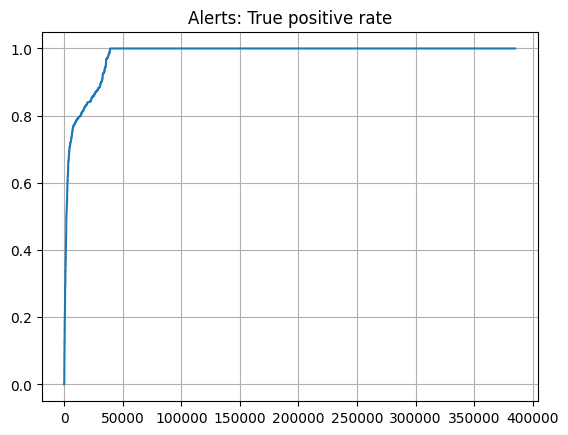

In [ ]:
TPR_milestones_perc = [0.1, 0.2, 0.5, 1]  # percentage in all nodes where to compute TPR values
AUC_milestones_perc = [1, 100]            # same, for AUC computation

print("\nStatistics for ALERTS")
print("Number of anomalous nodes:", np.sum(df_node_features_ego["nr_alerts"] > 0))
print("Weighted number of anomalies:", int(total_alerts))

p_perc = np.array(TPR_milestones_perc)/100*len(df_node_features_ego)
p_perc = p_perc.astype('int')
#print(p_perc)
print("True positives detected in first", *TPR_milestones_perc, "% anomalies")
#atpr = tpr_average[np.array(p_perc).astype('int')-1]
for i in range(len(p_perc)):
    print("{:.4f}".format(tpr_a_average[np.array(p_perc[i]).astype('int')]), end=' ')
print("")

a_perc = np.array(AUC_milestones_perc)/100*len(df_node_features_ego)
a_perc = a_perc.astype('int')
print("TPR AUC in first", *AUC_milestones_perc, "% anomalies")
for i in range(len(a_perc)):
    print("{:.4f}".format(np.average(tpr_a_average[:a_perc[i]])), end=' ')
print("")

plt.plot(tpr_a_average)
plt.title('Alerts: True positive rate')
plt.grid()
plt.show()

#Isolation Forest -nr_report

In [ ]:
FeatureList=['f_degree_in','f_degree_out' , 'f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','f_ego_nr_nodes',
             'f_ego_nr_edges','f_egored_degree_in','f_egored_degree_out','f_egored_amount_in','f_egored_amount_out','f_egored_nr_trans_in',
             'f_egored_nr_trans_out','f_egored_nr_nodes','f_egored_nr_edges']

In [ ]:
df_node_features_ego.head()

,NodeId,f_degree_in,f_degree_out,f_amount_in,f_amount_out,f_nr_trans_in,f_nr_trans_out,f_ego_nr_nodes,f_ego_nr_edges,f_egored_degree_in,f_egored_degree_out,f_egored_amount_in,f_egored_amount_out,f_egored_nr_trans_in,f_egored_nr_trans_out,f_egored_nr_nodes,f_egored_nr_edges,nr_alerts,nr_reports
0,0.0,0.0,4.0,0.0,41160.00,0.0,8.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,646.00,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,0.0,60.49,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,1.0,0.0,1884.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,1.0,0.0,111.00,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_node_features_ego.insert(1, "label", 0)

In [ ]:
df_node_features_ego
#df_node_features_ego["label"] = np.where(df_node_features_ego["nr_reports"] > 0, 1, 0)
df_node_features_ego["label"] = np.where(df_node_features_ego["nr_alerts"] > 0, 1, 0)

In [ ]:
np.where(df_node_features_ego["label"] == 1)

In [ ]:
df_node_features_ego

,NodeId,label,f_degree_in,f_degree_out,f_amount_in,f_amount_out,f_nr_trans_in,f_nr_trans_out,f_ego_nr_nodes,f_ego_nr_edges,f_egored_degree_in,f_egored_degree_out,f_egored_amount_in,f_egored_amount_out,f_egored_nr_trans_in,f_egored_nr_trans_out,f_egored_nr_nodes,f_egored_nr_edges,nr_alerts,nr_reports
0,0.0,0,0.0,4.0,0.0,41160.00,0.0,8.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0,0.0,1.0,0.0,646.00,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0,0.0,1.0,0.0,60.49,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0,0.0,1.0,0.0,1884.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0,0.0,1.0,0.0,111.00,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385095,385095.0,0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385096,385096.0,0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385097,385097.0,0,0.0,1.0,0.0,389904.00,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385098,385098.0,0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X=df_node_features_ego[FeatureList]
y=df_node_features_ego['label']

In [ ]:
# Split data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

# Create an IsolationForest instance
clf = IsolationForest(max_samples=100, random_state=0)

# Train the model
clf.fit(X_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the score for the test set
score = clf.score_samples(X_test)

print("Isolation Forest Score:", score)

Isolation Forest Score: [-0.3522052  -0.3522052  -0.35196089 ... -0.3522052  -0.33401767
 -0.33329744]


In [ ]:
auc_score = roc_auc_score(y_test, y_pred)
print("AUC score:", auc_score)

AUC score: 0.11902963804265138


In [ ]:
from sklearn.metrics import roc_curve, auc
scores = clf.decision_function(X)

In [ ]:
# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, scores)
roc_auc = auc(fpr, tpr)

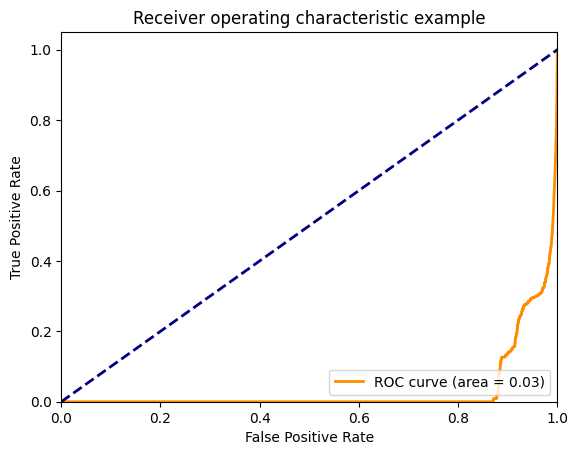

In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# My Method